#PCA

### 2D -> 1D

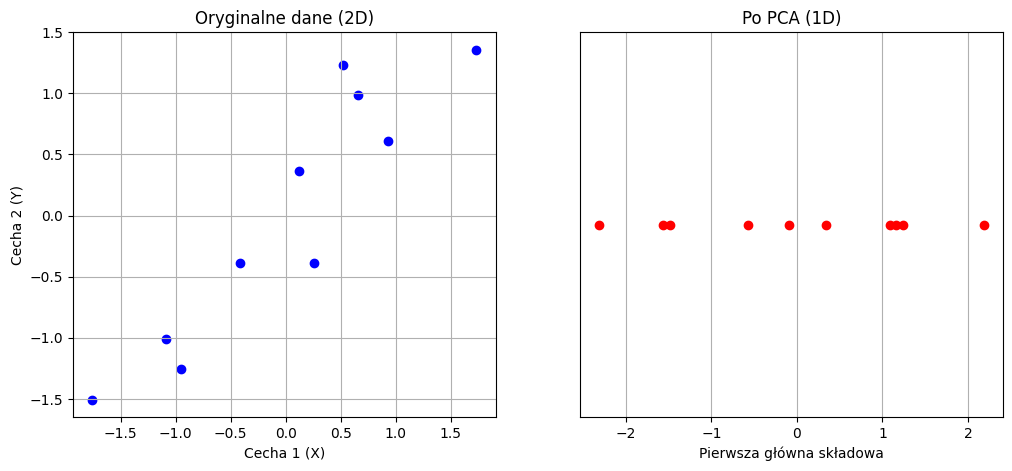

Wytłumaczona wariancja (procent): 96.30%


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.array([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3.0],
    [2.3, 2.7],
    [2.0, 1.6],
    [1.0, 1.1],
    [1.5, 1.6],
    [1.1, 0.9]
])

# 1️. Standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA (redukcja do 1 wymiaru)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)


# 3. Wizualizacja

### Oryginalne dane
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], color='blue')
plt.title("Oryginalne dane (2D)")
plt.xlabel("Cecha 1 (X)")
plt.ylabel("Cecha 2 (Y)")
plt.grid(True)

### Dane po PCA (1D) - rozciągnięte na osi X
plt.subplot(1, 2, 2)
plt.scatter(X_pca, np.zeros_like(X_pca), color='red')
plt.title("Po PCA (1D)")
plt.xlabel("Pierwsza główna składowa")
plt.yticks([])  # Ukrywamy oś Y
plt.grid(True)

plt.show()

print(f'Wytłumaczona wariancja (procent): {pca.explained_variance_ratio_[0] * 100:.2f}%')

### 3D -> 2D

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_redundant=5, n_classes=2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    # ('pca', PCA(n_components=0.95)),  # zachowaj 95% wariancji
    ("pca", PCA()),
    ("rfc", RandomForestClassifier(random_state=42))
])

param_distributions = {
    "pca__n_components": np.arange(2, 21),
    "rfc__n_estimators": [50, 100, 200],
    "rfc__max_depth": [3, 5, 10, None],
    "rfc__min_samples_split": [2, 5, 10]
}

search = RandomizedSearchCV(
    pipeline, param_distributions, n_iter=30,
    cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('rfc',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'pca__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'rfc__max_depth': [3, 5, 10, None],
                                        'rfc__min_samples_split': [2, 5, 10],
                                        'rfc__n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [12]:
search.best_params_

{'rfc__n_estimators': 200,
 'rfc__min_samples_split': 2,
 'rfc__max_depth': None,
 'pca__n_components': np.int64(15)}

In [13]:
y_pred = search.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.8866666666666667

In [14]:
best_pca = search.best_estimator_.named_steps['pca']

In [18]:
best_pca.n_components_

np.int64(15)

In [16]:
best_pca.explained_variance_ratio_

array([0.15757709, 0.13180112, 0.11277235, 0.07974189, 0.07734237,
       0.05742351, 0.0558226 , 0.05370528, 0.0516689 , 0.04863093,
       0.04376023, 0.04279086, 0.04011992, 0.02682012, 0.02002283])

In [20]:
best_pca.components_.shape

(15, 20)

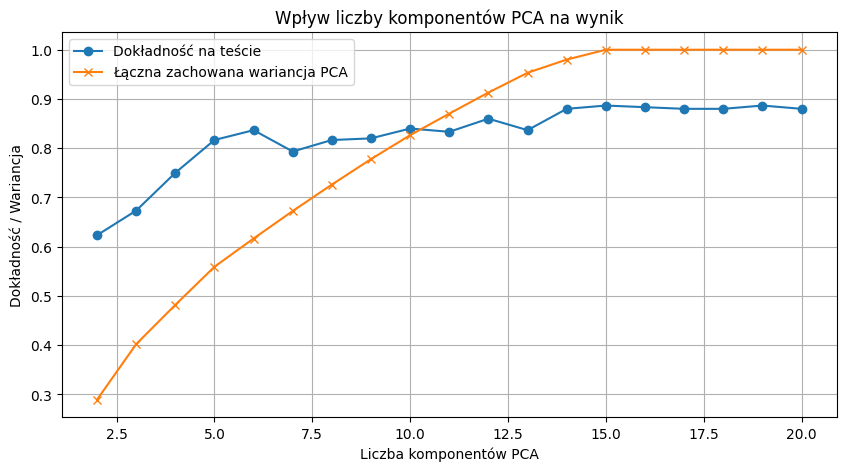

In [22]:
import pandas as pd

results = []

for n_components in range(2, 21):
    pipeline.set_params(pca__n_components=n_components)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_test, pipeline.predict(X_test))
    pca_step = pipeline.named_steps['pca']
    results.append({
        'n_components': n_components,
        'accuracy': acc,
        'variance_retained': pca_step.explained_variance_ratio_.sum()
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
plt.plot(results_df['n_components'], results_df['accuracy'], label='Dokładność na teście', marker='o')
plt.plot(results_df['n_components'], results_df['variance_retained'], label='Łączna zachowana wariancja PCA', marker='x')
plt.xlabel('Liczba komponentów PCA')
plt.ylabel('Dokładność / Wariancja')
plt.legend()
plt.grid(True)
plt.title('Wpływ liczby komponentów PCA na wynik')
plt.show()

## PCA for compression

In [24]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X.shape, y.shape

((1797, 64), (1797,))

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

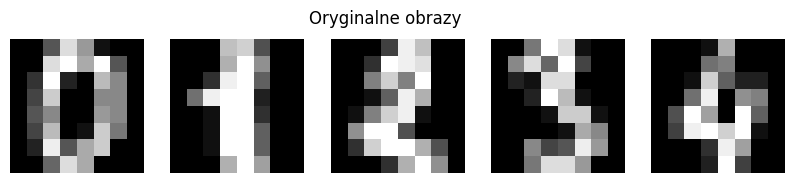

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle("Oryginalne obrazy")
plt.show()

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # zachowaj 95% wariancji
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)

print(f"PCA zredukowało wymiar z {X.shape[1]} do {pca.n_components_}")

PCA zredukowało wymiar z 64 do 40


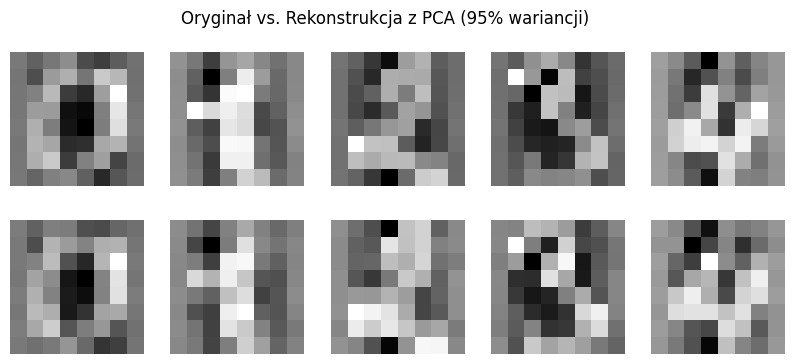

In [35]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes[0]):
    ax.imshow(X_scaled[i].reshape(8, 8), cmap='gray')
    ax.axis('off')

for i, ax in enumerate(axes[1]):
    ax.imshow(X_reconstructed[i].reshape(8, 8), cmap='gray')
    ax.axis('off')

plt.suptitle("Oryginał vs. Rekonstrukcja z PCA (95% wariancji)")
plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Dokładność klasyfikatora po PCA (95% wariancji): {acc:.3f}")

Dokładność klasyfikatora po PCA (95% wariancji): 0.963


## Losowa analiza PCA

*Jeżeli w hiperparametrze `svd_solver` wyznaczysz wartość "randomized", to moduł Scikit-Learn wykorzysta algorytm stochastyczny o nazwie **losowa analiza PCA (ang. randomized PCA)**, który szybko wyszukuje przybliżenie d pierwszych głównych składowych.*

In [41]:
rnd_pca = PCA(n_components=20, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Przyrostowa analiza PCA

*Jednym z problemów powyższych implementacji analizy PCA jest konieczność umieszczenia całego zbioru danych w pamięci po to, aby algorytm mógł działać. Na szczęście **przyrostowe algorytmy PCA (ang. incremental PCA — IPCA)** zostały tak zaprojektowane, że umożliwiają dzielenie zbioru danych uczących na minigrupy, które są następnie przekazywane pojedynczo do modelu. Rozwiązanie to
przydaje się w przypadku dużych zbiorów danych i do przetwarzania nowych przykładów w miarę ich pojawiania się.*

In [47]:
from sklearn.decomposition import IncrementalPCA

n_batches = 10
inc_pca = IncrementalPCA(n_components=20)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)